# Rossmann Sales Prediction

Forecasting sales is crucial for businesses to set expectations and plan for the future, essentially offering a glimpse into potential outcomes. Rossmann, with over 3,000 drug stores across seven European countries, requires its store managers to estimate daily sales up to six weeks ahead, using historical data from 1,115 stores. 

The goal is to predict future sales in the "Sales" column for a test set. I will conduct thorough analysis, including interactive exploratory analysis and feature engineering, and employ XGB for accurate sales forecasting.

### Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import HTML,display
import warnings
warnings.filterwarnings('ignore')

import datetime
import math
import calendar




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/rq/rtxryn3j4c91cgyhb885lxn40000gn/T/ipykernel_37615/2837899826.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML,display


### Importing Data

In [5]:
train = pd.read_csv('rossmann_train.csv')
test = pd.read_csv('rossmann_test.csv')
store = pd.read_csv('rossmann_store.csv')

# Print the shape of each DataFrame with descriptive text
print(f"Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.")
print(f"Store dataset has {store.shape[0]} rows and {store.shape[1]} columns.")

Train dataset has 1017209 rows and 9 columns.
Test dataset has 41088 rows and 8 columns.
Store dataset has 1115 rows and 10 columns.


### Joining

In [6]:
train.columns, test.columns, store.columns

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday'],
       dtype='object'),
 Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
        'SchoolHoliday'],
       dtype='object'),
 Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
        'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
       dtype='object'))

In [7]:
train.Store.nunique() == store.Store.nunique()

True

In [8]:
df = train.merge(store, how='left', left_on=train.Store, right_on=store.Store)
df.head()

,key_0,Store_x,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store_y,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,5,2015-07-31,5263,555,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,2,5,2015-07-31,6064,625,1,1,0,1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,3,5,2015-07-31,8314,821,1,1,0,1,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,5,2015-07-31,13995,1498,1,1,0,1,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,5,2015-07-31,4822,559,1,1,0,1,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset has 1017209 rows and 18 columns.


### Understanding the Data

In [10]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>Across the 1,115 stores, the sales feature shows a volatility of 3849.93, and the customers feature demonstrates a volatility of 464.41. The mean values for these features are 57,773.82 for sales and 633.15 for customers, respectively.</li>
    </ul>
</h3>

In [11]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [12]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 11)

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>There are no duplicates and Testing dataset has 11 null values.</li>
    </ul>
</h3>

In [13]:
print("Training data starts from: {}".format(train.Date.min()))
print("Training data end on: {}".format(train.Date.max()))
print()
print("Testing data starts from: {}".format(test.Date.min()))
print("Testing data end on: {}".format(test.Date.max()))

Training data starts from: 2013-01-01
Training data end on: 2015-07-31

Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


### Exploratory Data Analysis

In [14]:
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year

## I wish to explore seasonality and trend in the dataset and, and plan to use the insights gained to craft and preprocess features accordingly.

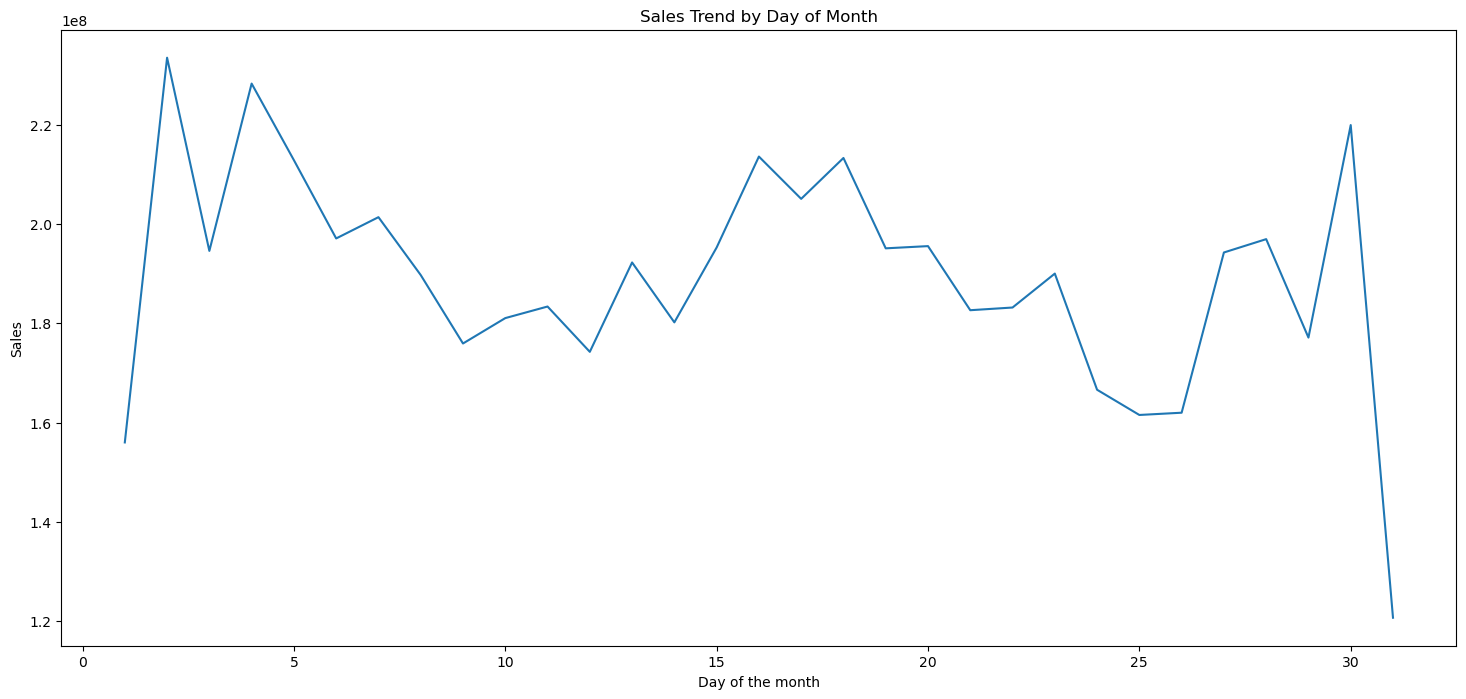

In [15]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Day).sum().Sales)
plt.title("Sales Trend by Day of Month")
plt.xlabel('Day of the month')
plt.ylabel('Sales')
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>The above plot indicates a trend where sales are highest at the beginning of the month and taper off towards the end, with the lowest sales typically occurring at the month's end. This pattern suggests a possible monthly cycle in consumer purchasing behavior, which could be influenced by factors such as payday cycles, monthly budgets, or promotional strategies that tend to start strong and fade as the month progresses.</li>
    </ul>
</h3>

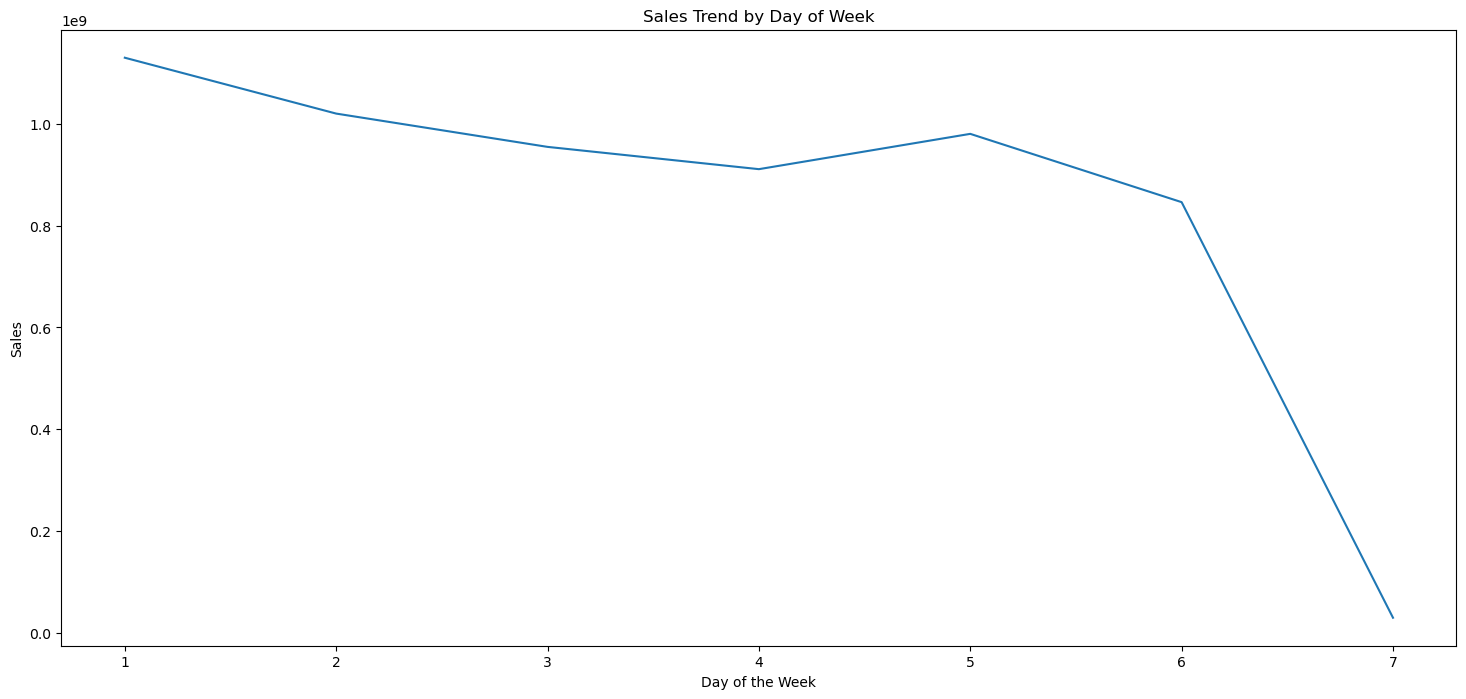

In [16]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.DayOfWeek).sum().Sales)
plt.title("Sales Trend by Day of Week")
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>The above plot shows a consistent pattern, with sales peaking early in the week, then gradually declining,leading to a significant drop as the week ends. This could imply that purchasing behavior is influenced by weekly cycles such as work schedules, weekly promotions, or consumer habits, where individuals may shop more at the beginning of the workweek or after the weekend. The steep decline towards day 7 could indicate a traditional lull in shopping activity, possibly due to store closures.</li>
    </ul>
</h3>

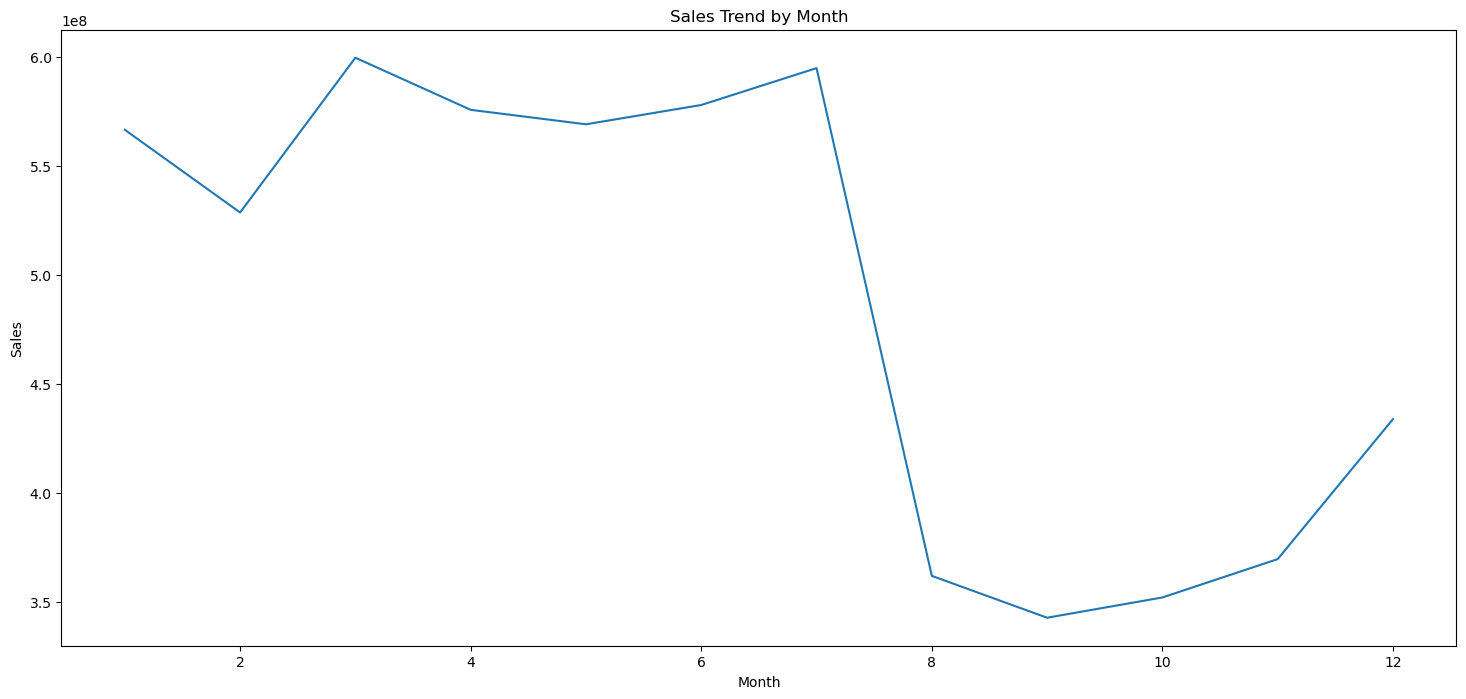

In [17]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Month).sum().Sales)
plt.title("Sales Trend by Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>Sales are significantly lower near the end of the year.</li>
    </ul>
</h3>

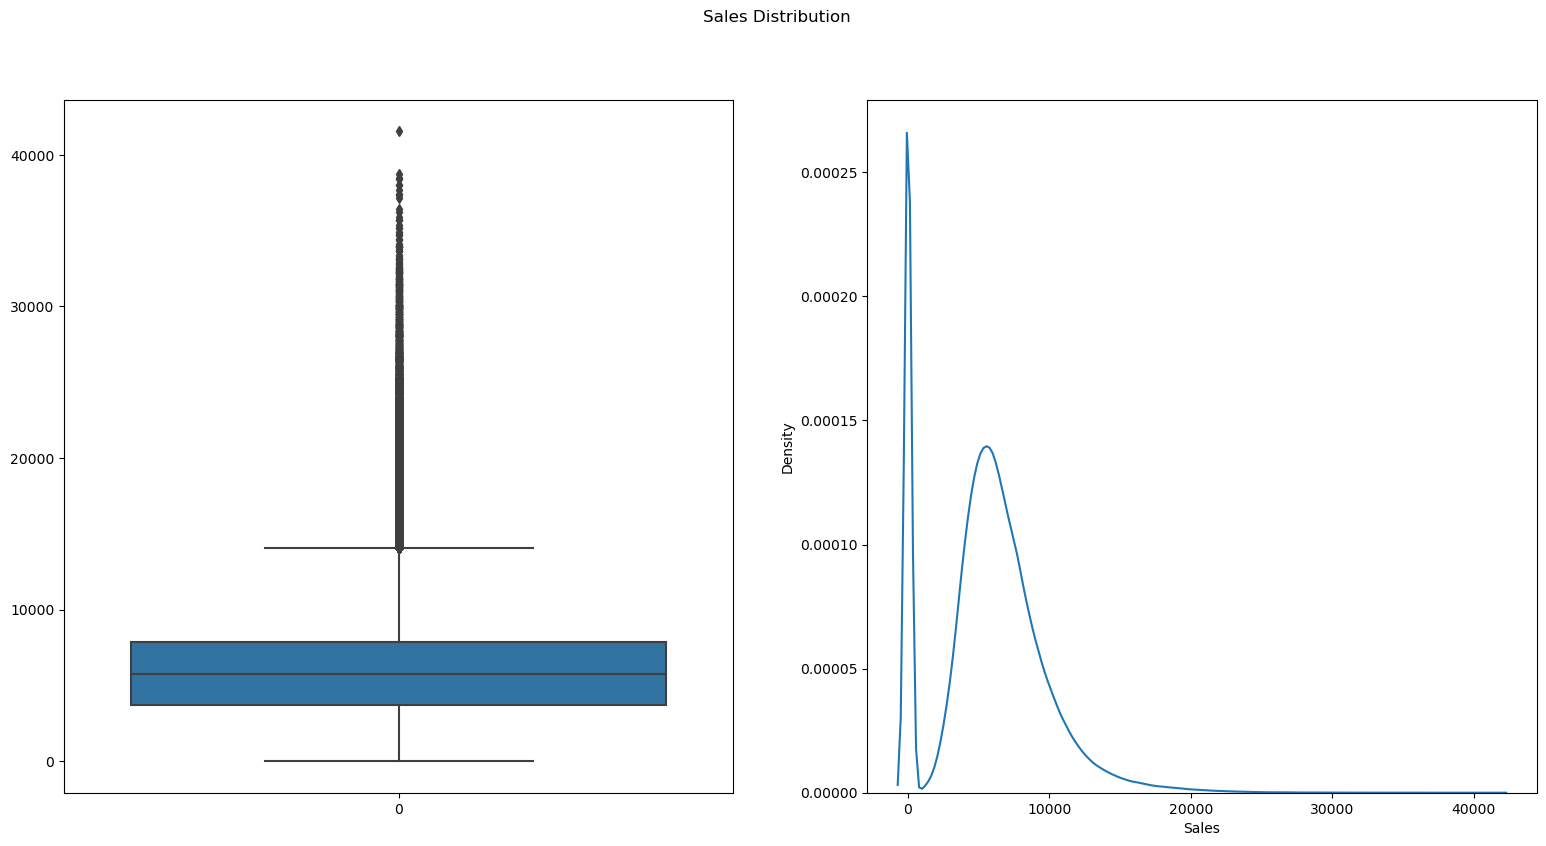

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(19,9))
sns.boxplot(train.Sales, ax=ax1)
sns.kdeplot(train.Sales, ax=ax2)
fig.suptitle('Sales Distribution', fontsize=12)
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>There is a significant number of days with zero sales, which may indicate data imputation to address missing values, as 0 daily sales is highly impossible. This could also suggest days when stores were not operational, potentially due to holidays or other closures. Further analysis is warranted to confirm these hypotheses.</li>
    </ul>
</h3>

In [19]:
df[df.Open==0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

### Seems like I was right! 172817 values are filled with 0. I will fill these values with np.NaN as some models like XGBoost can handle missing values and it might benifit from it. 

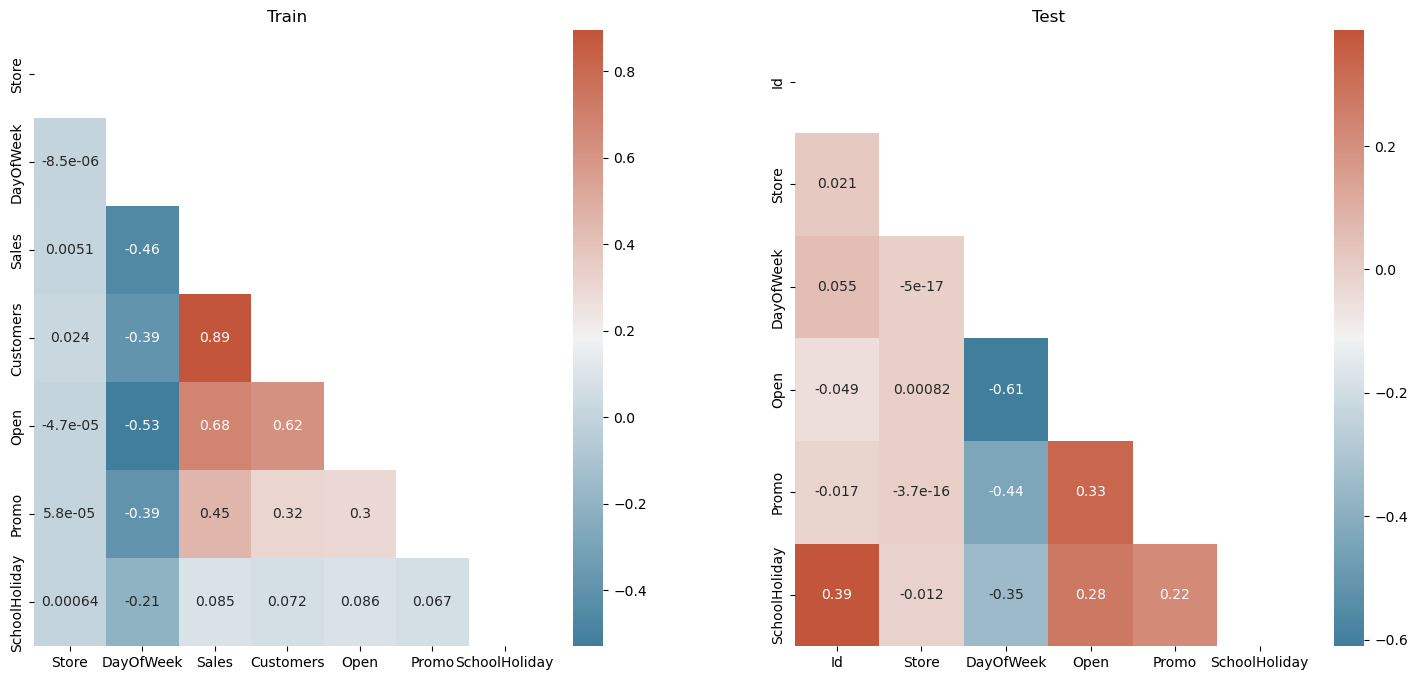

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(train.corr(), mask=mask, cmap=cmap, annot=True, ax=ax1)
ax1.set_title('Train')
corr = test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(test.corr(), mask=mask, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')
plt.show()

Sales are highly correlated with feature Customers and feature Open and moderately correlated with Promo. Lets see some more plots about this!

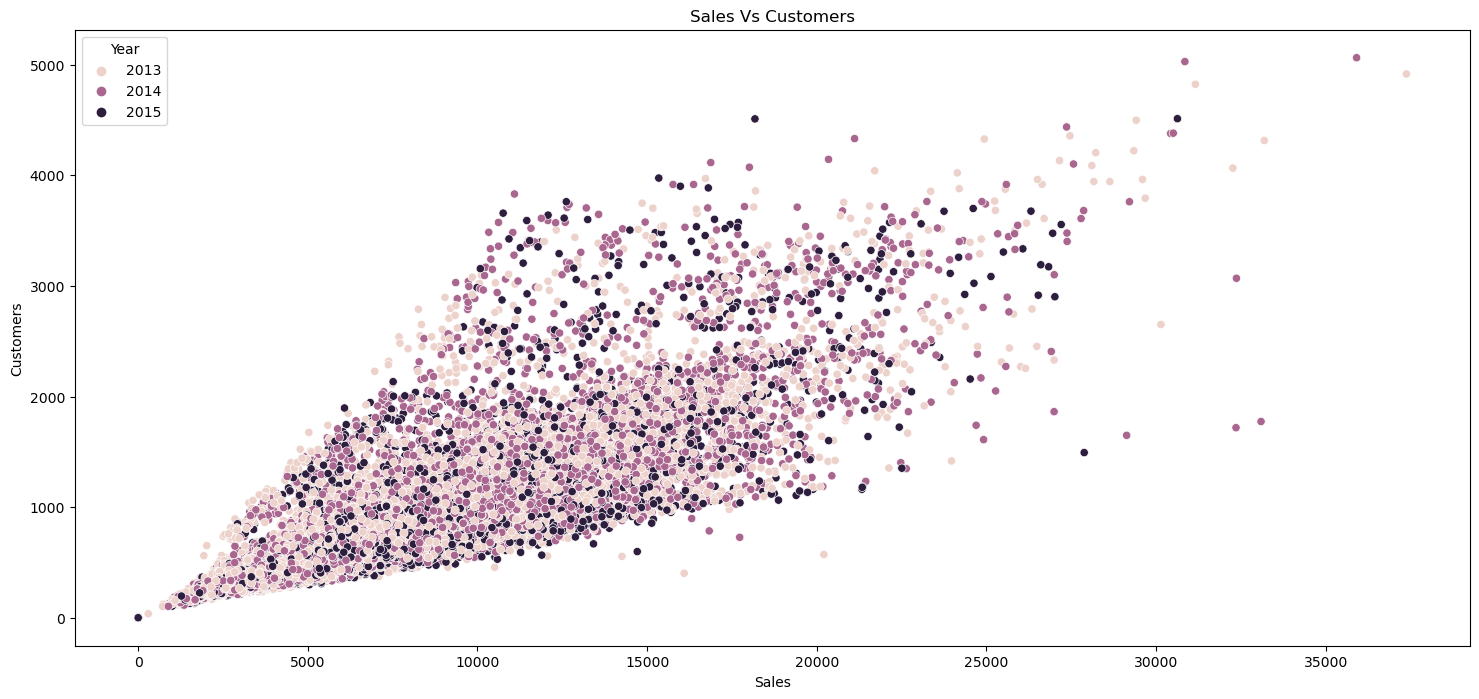

In [21]:
plt.figure(figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(x=temp_df.Sales, y=temp_df.Customers, hue=temp_df.Year)
plt.title("Sales Vs Customers")
plt.show()


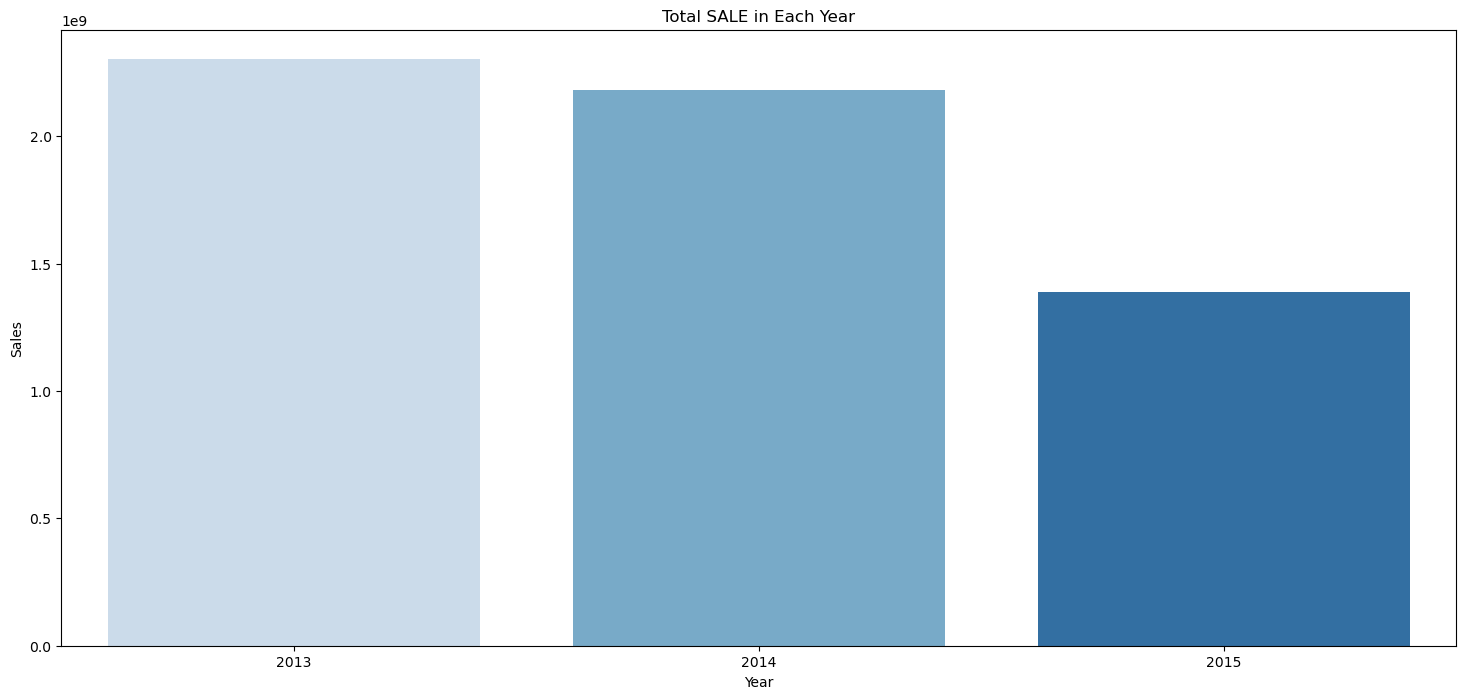

In [22]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.Year).sum()
# Use keyword arguments x and y instead of positional arguments
sns.barplot(x=temp_df.index, y=temp_df.Sales, palette='Blues')
plt.title("Total SALE in Each Year")
plt.xlabel('Year')
plt.show()


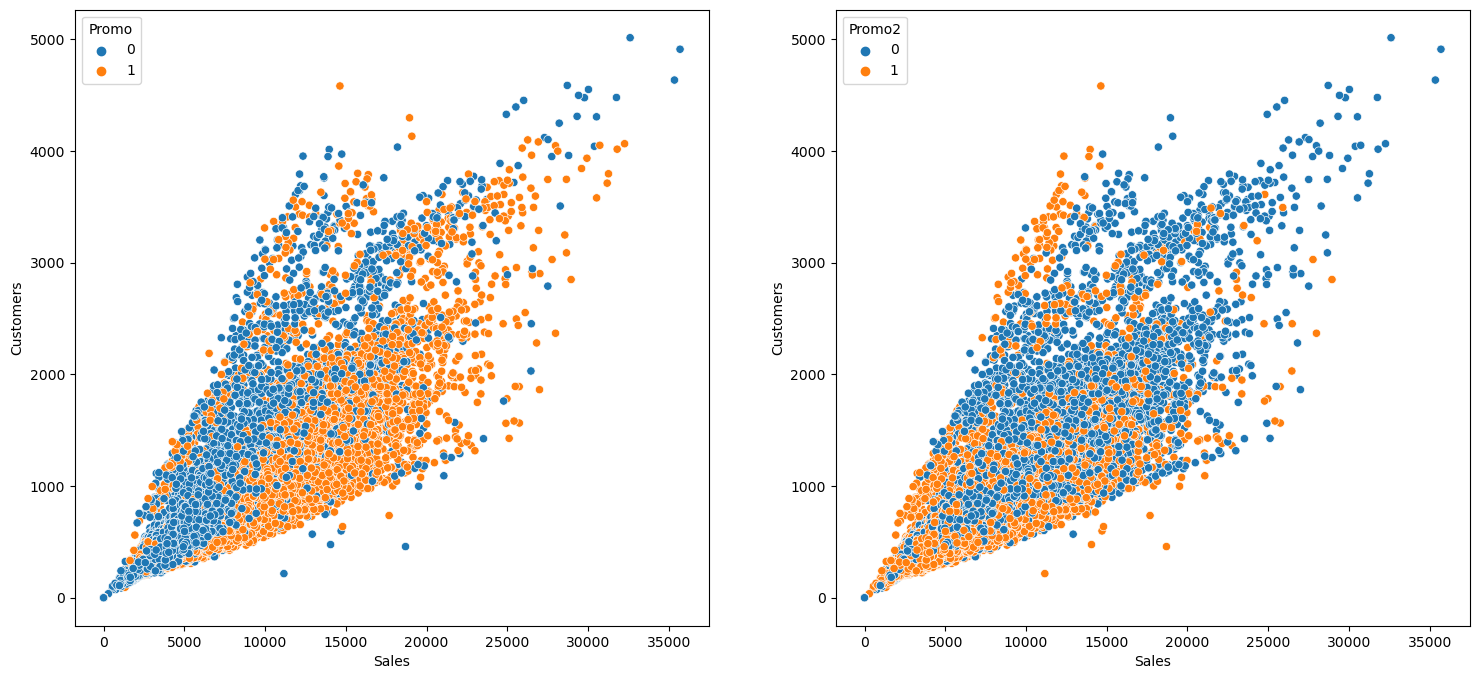

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(x=temp_df.Sales, y=temp_df.Customers, hue=df.Promo, ax=ax1)
sns.scatterplot(x=temp_df.Sales, y=temp_df.Customers, hue=df.Promo2, ax=ax2)
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>The side-by-side scatter plots compare the number of customers to sales, differentiated by two different promotion. Orange dots represent days with the promotion, while blue dots indicate days without it. The scatter plots clearly demonstrate that Promotion 1 leads to higher sales than Promotion 2. On days when Promotion 1 is active, sales figures are notably greater. This suggests that Promotion 1 has a more substantial impact on increasing sales, while Promotion 2 does not show a significant effect on sales enhancement.</li>
    </ul>
</h3>

In [24]:
#1 means store participated
df.groupby(df.Promo).Sales.mean()[1] > df.groupby(df.Promo2).Sales.mean()[1]

True

## Lets see if the type of store is a significant feature! Intuitively, stores inventory and atmosphere should be a huge factor. 

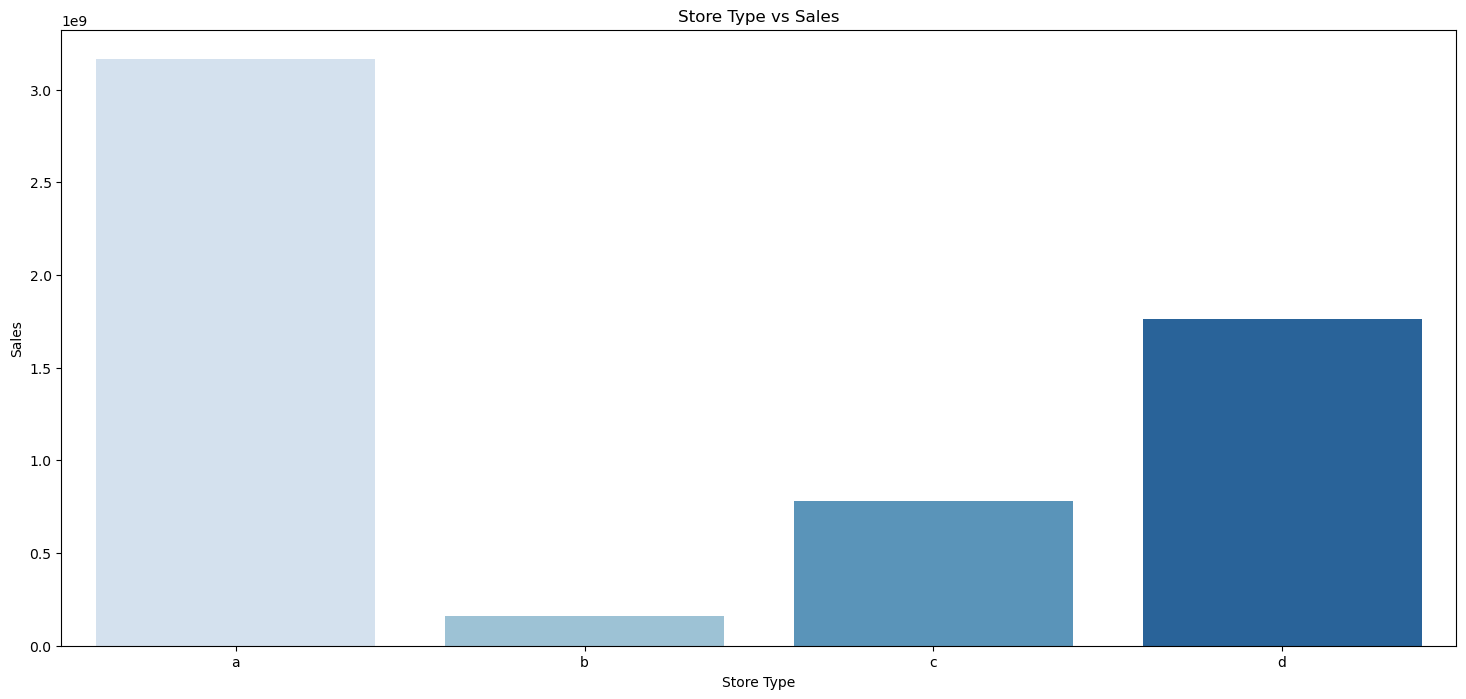

In [25]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.StoreType).sum()
sns.barplot(x=temp_df.index, y=temp_df.Sales, palette='Blues')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>Store A outperform all other stores in sales.</li>
    </ul>
</h3>

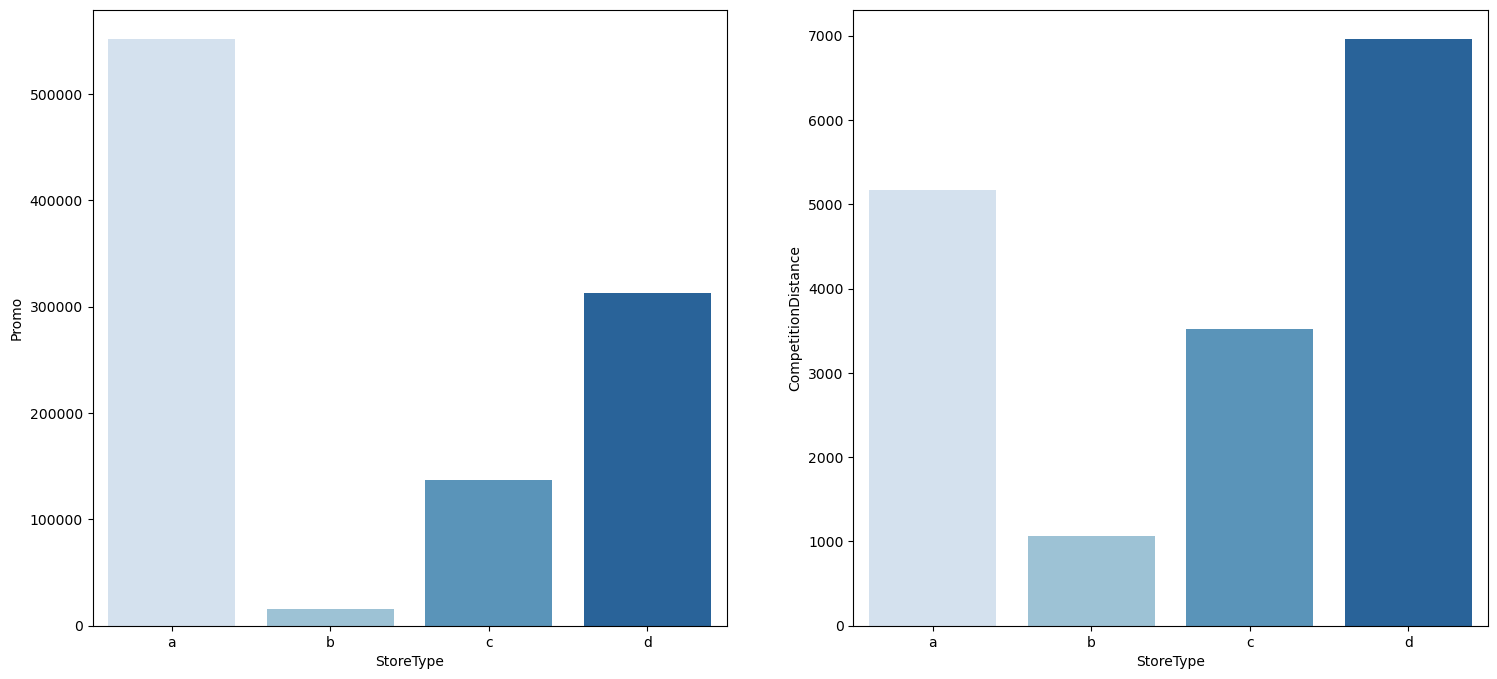

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.groupby(df.StoreType).count()
sns.barplot(x=temp_df.index, y=temp_df['Promo'], ax=ax1, palette='Blues')
temp_df = df.groupby(df.StoreType).mean()
sns.barplot(x=temp_df.index, y=temp_df['CompetitionDistance'], ax=ax2, palette='Blues')
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>Store A, holding a prime position based on competition distance (distance in meters to the nearest competitor store), leverages its advantageous location effectively. Yet, it is the extensive use of Promo'1' campaigns that truly sets it apart in sales performance compared to other stores. Promo appears to be the key driver in its superior sales figures.
    Other factors could be seasonality, trend etc. Lets see about trend!</li>
    </ul>
</h3>

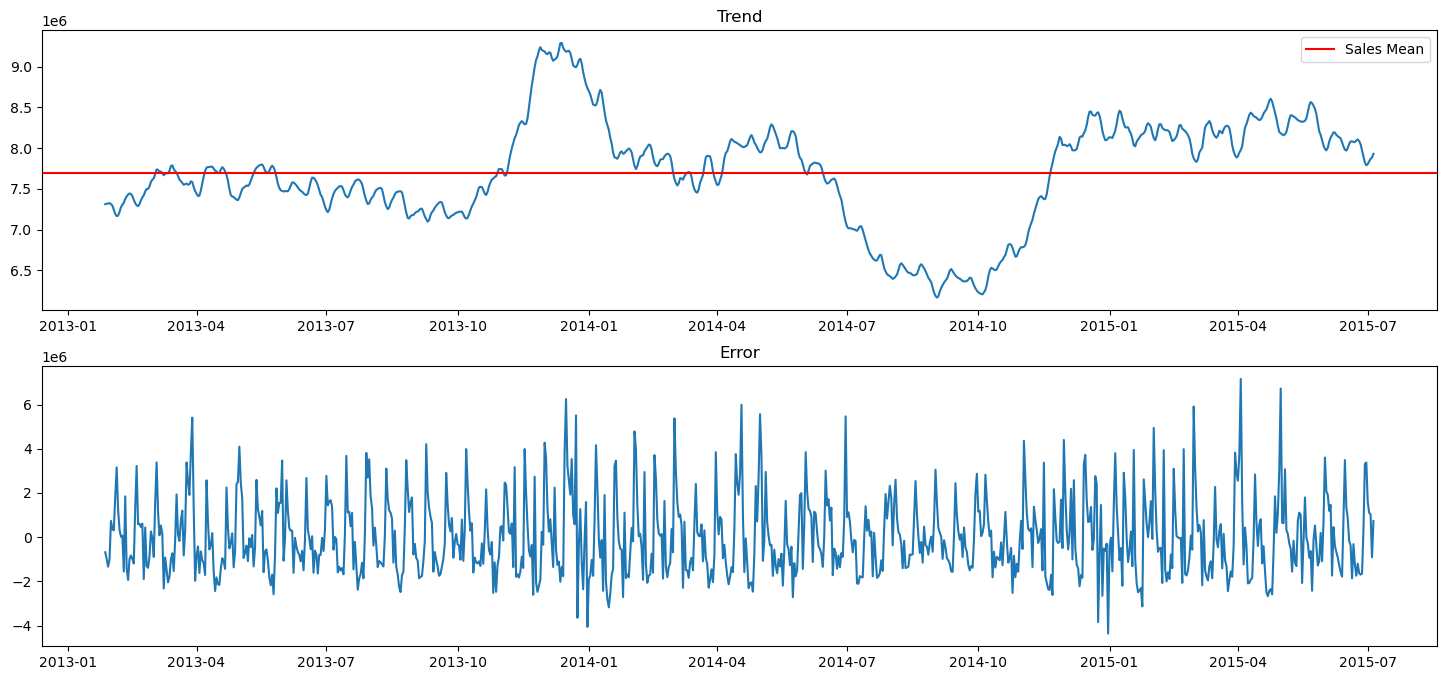

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = train.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', period=52)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(result.trend)
ax1.axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax1.legend()
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>The "Trend" plot exhibits a distinct peak towards the end of 2013, hinting at a potential seasonal sales upsurge or the impact of a successful marketing initiative. This is followed by a significant drop that extends into October 2014, where sales fall considerably below the average. This downward trend might be attributed to various factors, including the conclusion of a promotional campaign, new competition store open, market saturation, or a typical sales cycle fluctuation. After reaching this trough, sales begin a steady climb, eventually realigning with the average sales mean, suggesting a rebound from the earlier slump.</li>
    </ul>
</h3>

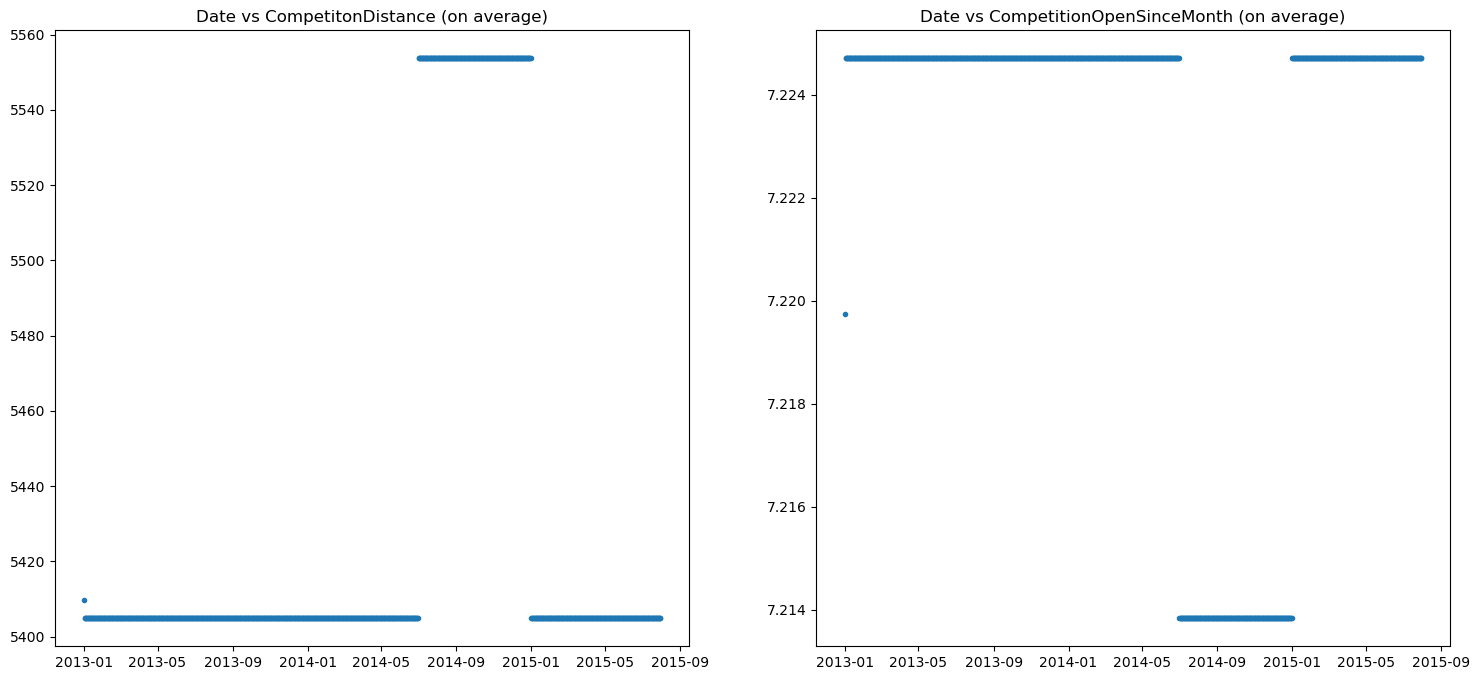

In [28]:
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df.groupby(temp_df.index).mean()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1.plot(temp_df.CompetitionDistance, '.')
ax1.set_title("Date vs CompetitonDistance (on average)")
ax2.plot(temp_df.CompetitionOpenSinceMonth, '.')
ax2.set_title("Date vs CompetitionOpenSinceMonth (on average)")
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>Towards the end of 2014, the data suggests a competitor store might have relocated to a further place or closed, as the average competition distance increased. This is just a guess, though. Understanding these shifts could help predict how stores might do in the future. I'm also curious if our stores ran fewer promotions when sales were dropping. Let's look into that.</li>
    </ul>
</h3>

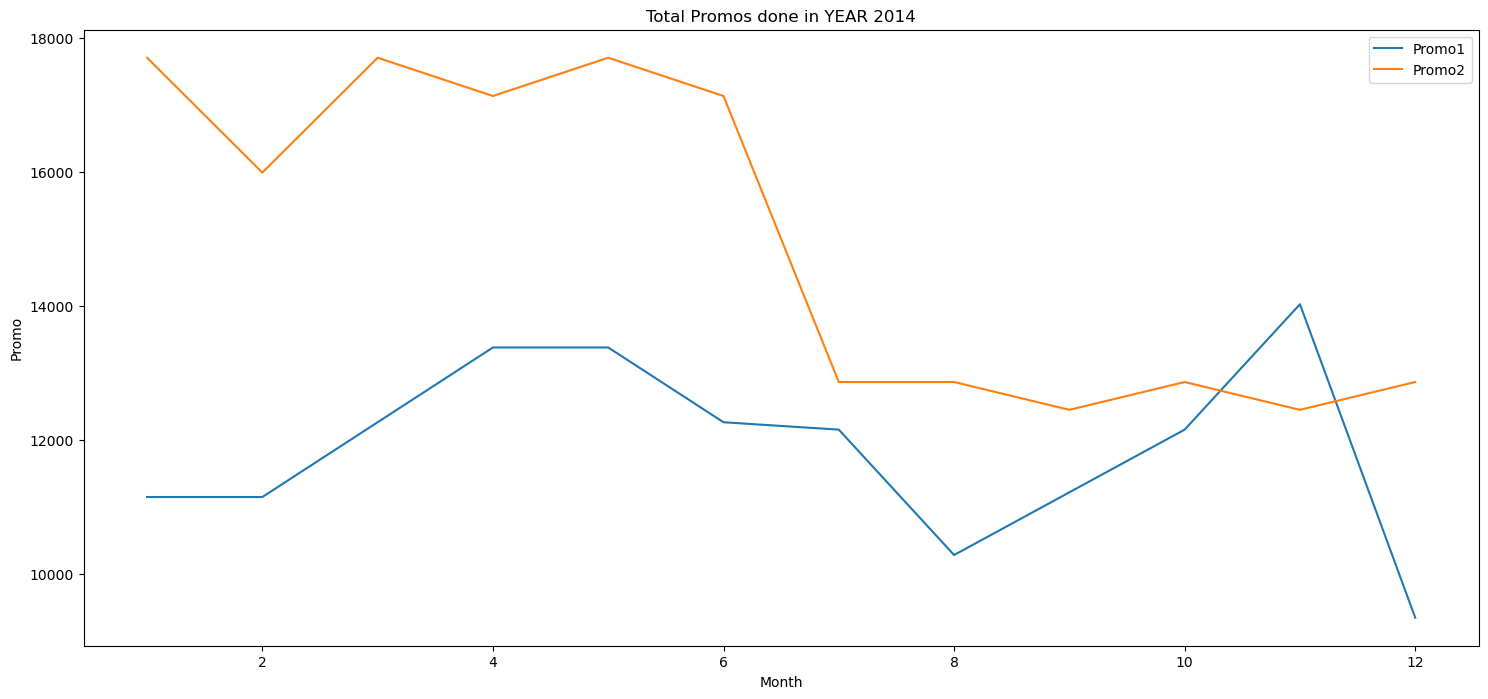

In [29]:
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df = temp_df[temp_df.Year==2014]
temp_df = temp_df.groupby(temp_df.Month).sum()
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')

plt.title('Total Promos done in YEAR 2014')
sns.lineplot(x=temp_df.index, y=temp_df.Promo, palette='Blues', label='Promo1')
sns.lineplot(x=temp_df.index, y=temp_df.Promo2, palette='Blues', label='Promo2')
plt.legend()
plt.show()

<h3> <b style='color:grey;font-size:22px;'>Findings </b>:
    <ul>
    <li>Promo1 shows a relatively stable trend with a slight dip in the middle of the year before a significant drop after November. Promo2, on the other hand, has more variability with several peaks and troughs, and it also ends lower than where it started at the beginning of the year.</li>
    </ul>
</h3>

# Feature Engineering and Preprocessing

In [30]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [31]:
# Combine the train and test data together 
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test])

In [32]:
#Converting date to required format
df.Date = pd.to_datetime(df.Date)

In [33]:
#Removing rows with Sales 0 when open 
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [34]:
df.StateHoliday.value_counts()


0    895961
0    131052
a     20440
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [35]:
#Unify the data types
df.StateHoliday = df.StateHoliday.map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'})
# Encoding for XG Boost 
df.StateHoliday = LabelEncoder().fit_transform(df.StateHoliday) #Encoding for XG Boost

In [36]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'is_train', 'Id'],
      dtype='object')

In [37]:
var_name = 'Date'

#addding day
df[var_name + 'Day'] = df[var_name].dt.day
#adding week
df[var_name + 'Week'] = df[var_name].dt.week
#adding month
df[var_name + 'Month'] = df[var_name].dt.month
#adding year
df[var_name + 'Year'] = df[var_name].dt.year 
#adding dayofyear
df[var_name + 'DayOfYear'] = df[var_name].dt.dayofyear

#removing Date
features_x.remove(var_name)

features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [38]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'is_train', 'Id', 'DateDay',
       'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear'],
      dtype='object')

In [39]:
#encoding StoreType
store.StoreType = LabelEncoder().fit_transform(store.StoreType)
#encoding Assortment
store.Assortment = LabelEncoder().fit_transform(store.Assortment)

In [40]:
store['PromoInterval']

0                    NaN
1        Jan,Apr,Jul,Oct
2        Jan,Apr,Jul,Oct
3                    NaN
4                    NaN
              ...       
1110     Jan,Apr,Jul,Oct
1111                 NaN
1112                 NaN
1113                 NaN
1114    Mar,Jun,Sept,Dec
Name: PromoInterval, Length: 1115, dtype: object

In [41]:
join_with = store['PromoInterval'].str.split(',').apply(pd.Series)


In [42]:
join_with

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,Jan,Apr,Jul,Oct
2,Jan,Apr,Jul,Oct
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1110,Jan,Apr,Jul,Oct
1111,NaN,NaN,NaN,NaN
1112,NaN,NaN,NaN,NaN
1113,NaN,NaN,NaN,NaN


In [43]:
join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')


In [44]:
join_with

,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval
0,NaN,NaN,NaN,NaN
1,Jan,Apr,Jul,Oct
2,Jan,Apr,Jul,Oct
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1110,Jan,Apr,Jul,Oct
1111,NaN,NaN,NaN,NaN
1112,NaN,NaN,NaN,NaN
1113,NaN,NaN,NaN,NaN


In [45]:
store = store.join(join_with)

In [46]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,0,0,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
1111,1112,2,2,1880.0,4.0,2006.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1112,1113,0,2,9260.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1113,1114,0,2,870.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#mapping month abbr to month number
def monthToNum(value):
    if(value=='Sept'):
        value='Sep'
    return list(calendar.month_abbr).index(value)

store['0_PromoInterval'] = store['0_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['1_PromoInterval'] = store['1_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['2_PromoInterval'] = store['2_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['3_PromoInterval'] = store['3_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [48]:
def compute_competition_open_date(row):
    if pd.notnull(row['CompetitionOpenSinceYear']) and pd.notnull(row['CompetitionOpenSinceMonth']):
        year = int(row['CompetitionOpenSinceYear'])
        month = int(row['CompetitionOpenSinceMonth'])
        # Format the date string and convert to datetime
        date_str = f"{year}-{month:02d}-01"
        date_formatted = pd.to_datetime(date_str, format='%Y-%m-%d').strftime('%Y%m%d')
        return date_formatted
    else:
        return np.nan

In [49]:
# Apply the function to each row and create a new column for the formatted date
store['CompetitionOpen'] = store.apply(compute_competition_open_date, axis=1)

In [50]:
store['CompetitionOpen'].shape

(1115,)

In [51]:
def compute_promo2_start_date(row):
    if pd.notnull(row['Promo2SinceYear']) and pd.notnull(row['Promo2SinceWeek']):
        year = int(row['Promo2SinceYear'])
        week = int(row['Promo2SinceWeek'])
        # Calculate the date assuming the week starts on Monday
        date = pd.to_datetime(f"{year} {week} 1", format='%G %V %u')
        return date.strftime('%Y%m%d')
    else:
        return np.nan

# Apply the function to the DataFrame
store['PromoSince'] = store.apply(compute_promo2_start_date, axis=1)

In [52]:
store['PromoSince'].shape

(1115,)

In [53]:
store.head(100)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval,CompetitionOpen,PromoSince
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20080901,NaN
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20071101,20100329
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20061201,20110404
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20090901,NaN
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20150401,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,0,8780.0,2.0,2005.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20050201,20090907
96,97,3,2,8980.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,98,3,2,15140.0,12.0,2006.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20061201,20120102
98,99,2,2,2030.0,11.0,2003.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3.0,6.0,9.0,12.0,20031101,20120528


In [54]:
#1_PromoInterval, 2_PromoInterval, 3_PromoInterval irrelevent
store_features = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
                  'PromoSince', '0_PromoInterval']


In [55]:
df = pd.merge(df, store[store_features], how='left', on=['Store'])

In [56]:
features_x = list(set(features_x + store_features))

In [57]:
for feature in features_x:
    df[feature] = df[feature].fillna(-9999) #out of range value for model

In [58]:
df.dtypes

Store                           int64
DayOfWeek                       int64
Date                   datetime64[ns]
Sales                         float64
Customers                     float64
Open                          float64
Promo                           int64
StateHoliday                    int64
SchoolHoliday                   int64
is_train                        int64
Id                            float64
DateDay                         int64
DateWeek                        int64
DateMonth                       int64
DateYear                        int64
DateDayOfYear                   int64
StoreType                       int64
Assortment                      int64
CompetitionDistance           float64
CompetitionOpen                object
PromoSince                     object
0_PromoInterval               float64
dtype: object

In [59]:
df['DateInt'] = df.Date.dt.strftime('%Y%m%d').map(int) #mapping to Int
df['CompetitionOpen'] = df.CompetitionOpen.map(int)
df['PromoSince'] = df.PromoSince.map(int)

In [60]:
df['Zscore'] = (df.Sales - df.Sales.mean())/df.Sales.std()

In [61]:
thresh=4.0
def check_outlier(value):
    if(value>=thresh):
        return True
    else:
        return False

df['Outlier'] = df.Zscore.apply(check_outlier)

In [62]:
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day



In [63]:
df_store = pd.merge(store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [64]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0_PromoInterval,1_PromoInterval,2_PromoInterval,3_PromoInterval,CompetitionOpen,PromoSince,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20080901,NaN,3754.397980,444.972727,8.437366
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20071101,20100329,4122.991507,486.045648,8.482725
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,4.0,7.0,10.0,20061201,20110404,5462.889899,590.212121,9.255808
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20090901,NaN,8021.769639,1100.057325,7.292138
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20150401,NaN,3867.110403,444.360934,8.702634


In [65]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,...,DateDayOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpen,PromoSince,0_PromoInterval,DateInt,Zscore,Outlier
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1,...,212,2,0,1270.0,20080901,-9999,-9999.0,20150731,-0.132767,False
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,1,...,212,0,0,570.0,20071101,20100329,1.0,20150731,0.075296,False
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,1,...,212,0,0,14130.0,20061201,20110404,1.0,20150731,0.659742,False
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,1,...,212,2,2,620.0,20090901,-9999,-9999.0,20150731,2.135404,False
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,1,...,212,0,0,29910.0,20150401,-9999,-9999.0,20150731,-0.247318,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058238,1111,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,213,0,0,1900.0,20140601,20130729,1.0,20150801,NaN,False
1058239,1112,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,213,2,2,1880.0,20060401,-9999,-9999.0,20150801,NaN,False
1058240,1113,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,213,0,2,9260.0,-9999,-9999,-9999.0,20150801,NaN,False
1058241,1114,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,213,0,2,870.0,-9999,-9999,-9999.0,20150801,NaN,False


In [66]:
df.shape


(1058243, 25)

### Merge df with store information. 

In [67]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [68]:
holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().StateHoliday
df = pd.merge(df, holidays_each_day_of_week.reset_index(name='HolidaysEachDayOfWeek'), on=['DayOfWeek'])

In [69]:
school_holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().SchoolHoliday
df = pd.merge(df, school_holidays_each_day_of_week.reset_index(name='SchoolHolidaysEachDayOfWeek'), on=['DayOfWeek'])

In [70]:
promo_each_day_of_week = df.groupby(df.DayOfWeek).sum().Promo
df = pd.merge(df, promo_each_day_of_week.reset_index(name='PromoEachDayOfWeek'), on=['DayOfWeek'])

In [71]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,...,0_PromoInterval,DateInt,Zscore,Outlier,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,HolidaysEachDayOfWeek,SchoolHolidaysEachDayOfWeek,PromoEachDayOfWeek
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1,...,-9999.0,20150731,-0.132767,False,3754.397980,444.972727,8.437366,12291,39429,80145
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,1,...,1.0,20150731,0.075296,False,4122.991507,486.045648,8.482725,12291,39429,80145
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,1,...,1.0,20150731,0.659742,False,5462.889899,590.212121,9.255808,12291,39429,80145
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,1,...,-9999.0,20150731,2.135404,False,8021.769639,1100.057325,7.292138,12291,39429,80145
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,1,...,-9999.0,20150731,-0.247318,False,3867.110403,444.360934,8.702634,12291,39429,80145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058238,1111,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,1.0,20150801,NaN,False,4132.400000,355.437374,11.626239,579,3394,0
1058239,1112,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,-9999.0,20150801,NaN,False,8054.842424,659.874747,12.206623,579,3394,0
1058240,1113,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,-9999.0,20150801,NaN,False,5248.729293,567.829293,9.243499,579,3394,0
1058241,1114,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,-9999.0,20150801,NaN,False,16366.247475,2534.890909,6.456391,579,3394,0


In [72]:
holidays_next_week=[]
holidays_next_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index + datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=15)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_next_week.append(school_holidays+state_holidays)
    holidays_next_week_index.append(index)
    
holidays_next_week = pd.Series(holidays_next_week)
holidays_next_week.count()

990

In [73]:
holidays_this_week=[]
holidays_this_week_index = []
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index 
    end_range = index + datetime.timedelta(days=7)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_this_week.append(school_holidays+state_holidays)
    holidays_this_week_index.append(index)
    
holidays_this_week = pd.Series(holidays_this_week)
holidays_this_week.count()

990

In [74]:
holidays_last_week=[]
holidays_last_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index - datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=1)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_last_week.append(school_holidays+state_holidays)
    holidays_last_week_index.append(index)
    
holidays_last_week = pd.Series(holidays_next_week)
holidays_last_week.count()

990

In [75]:
temp_df = pd.DataFrame({'HolidaysNextWeek':holidays_next_week, 'Date': holidays_next_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [76]:
temp_df = pd.DataFrame({'HolidaysThisWeek':holidays_this_week, 'Date': holidays_this_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [77]:
temp_df = pd.DataFrame({'HolidaysLastWeek':holidays_last_week, 'Date': holidays_last_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [78]:
holidays_features = ['HolidaysEachDayOfWeek', 'SchoolHolidaysEachDayOfWeek', 'PromoEachDayOfWeek', 
                     'HolidaysNextWeek', 'HolidaysThisWeek', 'HolidaysLastWeek']

features_x = list(set(features_x + holidays_features))

In [79]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,...,Outlier,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,HolidaysEachDayOfWeek,SchoolHolidaysEachDayOfWeek,PromoEachDayOfWeek,HolidaysNextWeek,HolidaysThisWeek,HolidaysLastWeek
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1,...,False,3754.397980,444.972727,8.437366,12291,39429,80145,4860,5483,4860
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,1,...,False,4122.991507,486.045648,8.482725,12291,39429,80145,4860,5483,4860
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,1,...,False,5462.889899,590.212121,9.255808,12291,39429,80145,4860,5483,4860
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,1,...,False,8021.769639,1100.057325,7.292138,12291,39429,80145,4860,5483,4860
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,1,...,False,3867.110403,444.360934,8.702634,12291,39429,80145,4860,5483,4860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058238,1111,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,False,4132.400000,355.437374,11.626239,579,3394,0,4138,4682,4138
1058239,1112,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,False,8054.842424,659.874747,12.206623,579,3394,0,4138,4682,4138
1058240,1113,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,False,5248.729293,567.829293,9.243499,579,3394,0,4138,4682,4138
1058241,1114,6,2015-08-01,NaN,NaN,1.0,0,0,0,0,...,False,16366.247475,2534.890909,6.456391,579,3394,0,4138,4682,4138


In [80]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'is_train', 'Id', 'DateDay',
       'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpen', 'PromoSince',
       '0_PromoInterval', 'DateInt', 'Zscore', 'Outlier', 'SalesPerDay',
       'CustomersPerDay', 'SalesPerCustomersPerDay', 'HolidaysEachDayOfWeek',
       'SchoolHolidaysEachDayOfWeek', 'PromoEachDayOfWeek', 'HolidaysNextWeek',
       'HolidaysThisWeek', 'HolidaysLastWeek'],
      dtype='object')

In [81]:
for i, (day, promo_count) in enumerate(promo_each_day_of_week.items(), start=1):
    print(f"Day {day}: {promo_count} promotions")



Day 1: 81183 promotions
Day 2: 81000 promotions
Day 3: 80998 promotions
Day 4: 80997 promotions
Day 5: 80145 promotions
Day 6: 0 promotions
Day 7: 0 promotions


In [96]:
#Most Promos are done on DayofWeek 1
df['DaysTillMaxPromo'] = df.DayOfWeek.apply(lambda x: (8 - x) % 7)

In [83]:
df['PromoTomorrow'] = df.Promo.shift(-1)
df['PromoYesterday'] = df.Promo.shift(1)

In [84]:
promo_features = ['DaysTillMaxPromo', 'PromoTomorrow', 'PromoYesterday']

features_x = list(set(features_x + promo_features))

In [85]:
df.Sales = df.Sales.apply(lambda x: np.nan if x == 0 else x) #Convert 0 to NaNs

In [86]:
df.loc[df['is_train'] == 1, 'SalesLog'] = np.log(1+df.loc[df['is_train'] == 1]['Sales']) #Transforming Sales to 1+log

In [87]:
len(features_x)

29

In [88]:
features_x

['PromoEachDayOfWeek',
 'DateYear',
 'DateDayOfYear',
 'StoreType',
 'Open',
 'StateHoliday',
 'HolidaysNextWeek',
 'DayOfWeek',
 'HolidaysEachDayOfWeek',
 'Assortment',
 'DateDay',
 'Promo',
 'HolidaysLastWeek',
 '0_PromoInterval',
 'SalesPerDay',
 'CompetitionOpen',
 'HolidaysThisWeek',
 'DaysTillMaxPromo',
 'SchoolHolidaysEachDayOfWeek',
 'PromoTomorrow',
 'Store',
 'DateWeek',
 'SalesPerCustomersPerDay',
 'CustomersPerDay',
 'CompetitionDistance',
 'PromoYesterday',
 'SchoolHoliday',
 'PromoSince',
 'DateMonth']

In [89]:
df.shape

(1058243, 38)

In [90]:
df.isnull().sum().sum()

1527143

# Modelling

In [91]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [92]:
import xgboost as xgb

In [93]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [95]:
features_x

['PromoEachDayOfWeek',
 'DateYear',
 'DateDayOfYear',
 'StoreType',
 'Open',
 'StateHoliday',
 'HolidaysNextWeek',
 'DayOfWeek',
 'HolidaysEachDayOfWeek',
 'Assortment',
 'DateDay',
 'Promo',
 'HolidaysLastWeek',
 '0_PromoInterval',
 'SalesPerDay',
 'CompetitionOpen',
 'HolidaysThisWeek',
 'DaysTillMaxPromo',
 'SchoolHolidaysEachDayOfWeek',
 'PromoTomorrow',
 'Store',
 'DateWeek',
 'SalesPerCustomersPerDay',
 'CustomersPerDay',
 'CompetitionDistance',
 'PromoYesterday',
 'SchoolHoliday',
 'PromoSince',
 'DateMonth']

In [97]:
data = df.loc[(df['is_train'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x], 
                                                    data[features_y], 
                                                    test_size=0.1, 
                                                    random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6, 
         'objective': 'reg:squarederror',}

plst = list(param.items())

model = xgb.train(plst, dtrain, num_round, evallist, 
                  feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

(757442, 29) (757442, 1) (84161, 29) (84161, 1)
[0]	train-rmse:0.41763	train-rmspe:0.55530	test-rmse:0.41787	test-rmspe:0.52474
[250]	train-rmse:0.15473	train-rmspe:0.22780	test-rmse:0.15497	test-rmspe:0.17478
[500]	train-rmse:0.12784	train-rmspe:0.19398	test-rmse:0.12913	test-rmspe:0.14382
[750]	train-rmse:0.11717	train-rmspe:0.17633	test-rmse:0.11935	test-rmspe:0.13220
[1000]	train-rmse:0.11056	train-rmspe:0.16093	test-rmse:0.11337	test-rmspe:0.12524
[1250]	train-rmse:0.10616	train-rmspe:0.15262	test-rmse:0.10952	test-rmspe:0.12084
[1500]	train-rmse:0.10264	train-rmspe:0.14794	test-rmse:0.10652	test-rmspe:0.11760
[1750]	train-rmse:0.09962	train-rmspe:0.14230	test-rmse:0.10404	test-rmspe:0.11493
[2000]	train-rmse:0.09716	train-rmspe:0.13800	test-rmse:0.10209	test-rmspe:0.11284
[2250]	train-rmse:0.09506	train-rmspe:0.13512	test-rmse:0.10046	test-rmspe:0.11112
[2500]	train-rmse:0.09306	train-rmspe:0.13002	test-rmse:0.09895	test-rmspe:0.10952
[2750]	train-rmse:0.09134	train-rmspe:0.12504

<Figure size 1800x800 with 0 Axes>

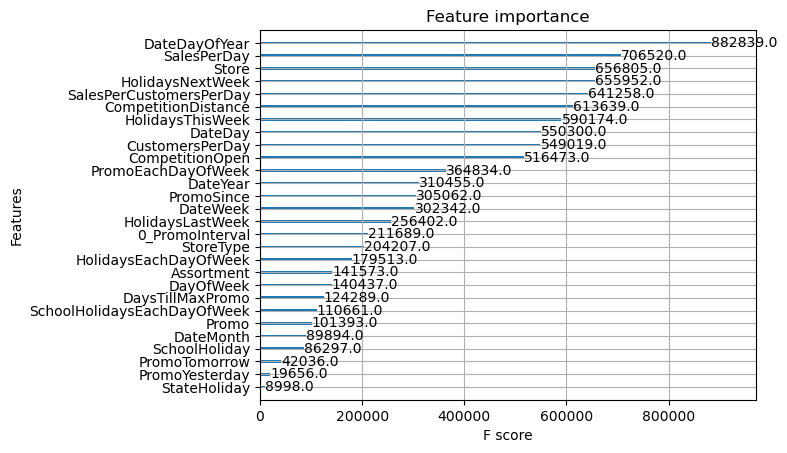

In [98]:
#Print Feature Importance
plt.figure(figsize=(18,8))
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [ ]:
submit = df.loc[df['is_train'] == 0]
dsubmit = xgb.DMatrix(submit[features_x])
predictions = model.predict(dsubmit)

df_predictions = submit['Id'].reset_index()
df_predictions['Id'] = df_predictions['Id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('solution.csv', index=False)